# Reintento de parcial Dataset Inmobiliaria

## Importar librerías y dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/carlos-paezf/Deep_Learning/master/Primer_Corte/data_inmueble.csv", encoding='utf-8')

## Conocer la data

El dataset base se encuentra en el [repositorio del docente](https://github.com/luisFernandoCastellanosG/Machine_learning/blob/master/Databasets/data_inmobiliaria.csv). Algunos cambios realizados son los siguientes:

- Cambio en el formato de las fechas, de ***'00/00/0000'*** a ***00000000***
- En el indice 201, se cambio el dato de ***BOGOTA- D.C.*** a ***BOGOTA***

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   COD_INMUEBLE          6791 non-null   int64  
 1   NOM_SUCURSAL          6791 non-null   object 
 2   NOM_BARRIO            6791 non-null   object 
 3   NOM_CIUDAD            6791 non-null   object 
 4   ESTRATO               6734 non-null   object 
 5   TIPO_INMUEBLE         6791 non-null   object 
 6   AREA                  6791 non-null   int64  
 7   VLR_CANON             6791 non-null   int64  
 8   VLR_ADMINISTRACION    6791 non-null   int64  
 9   FECHA_CONSIGNACION    6791 non-null   int64  
 10  FECHA_RECONSIGNACION  383 non-null    float64
 11  FECHA_CONTRATO        6791 non-null   int64  
 12  COD_ESTADO_CONTRATO   6791 non-null   object 
dtypes: float64(1), int64(6), object(6)
memory usage: 689.8+ KB


In [ ]:
data.describe()

,COD_INMUEBLE,AREA,VLR_CANON,VLR_ADMINISTRACION,FECHA_CONSIGNACION,FECHA_RECONSIGNACION,FECHA_CONTRATO
count,6791.000000,6791.000000,6.791000e+03,6.791000e+03,6.791000e+03,3.830000e+02,6.791000e+03
mean,3396.000000,46.357385,1.112686e+06,1.474904e+05,1.574091e+07,1.881163e+07,1.639169e+07
std,1960.537171,26.973165,1.427193e+06,1.583145e+05,9.804221e+06,7.547198e+06,9.767587e+06
min,1.000000,10.000000,0.000000e+00,0.000000e+00,1.012018e+06,3.072020e+06,1.190000e+04
25%,1698.500000,23.000000,6.539400e+05,0.000000e+00,7.092011e+06,1.307202e+07,7.122013e+06
50%,3396.000000,39.000000,8.123400e+05,1.480000e+05,1.512202e+07,2.101202e+07,1.702202e+07
75%,5093.500000,70.000000,1.052160e+06,2.300000e+05,2.505201e+07,2.504202e+07,2.601200e+07
max,6791.000000,100.000000,2.931983e+07,5.116724e+06,3.112202e+07,3.107202e+07,3.110202e+07


In [ ]:
data.isnull().sum()

COD_INMUEBLE               0
NOM_SUCURSAL               0
NOM_BARRIO                 0
NOM_CIUDAD                 0
ESTRATO                   57
TIPO_INMUEBLE              0
AREA                       0
VLR_CANON                  0
VLR_ADMINISTRACION         0
FECHA_CONSIGNACION         0
FECHA_RECONSIGNACION    6408
FECHA_CONTRATO             0
COD_ESTADO_CONTRATO        0
dtype: int64

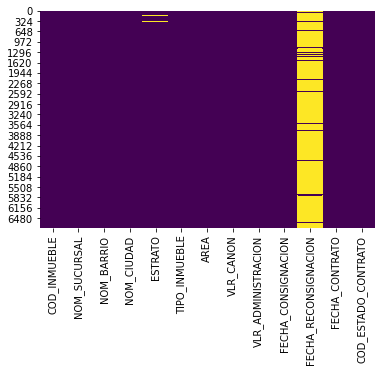

In [ ]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Eliminar columna con multiples datos nulos

La columna FECHA_RECONSIGNACION presenta un porcentaje de datos nulos mayor al 50%, por lo tanto para evitar sesgos en los resultados, se decide eliminar dicha columna

In [ ]:
data.drop(labels=['FECHA_RECONSIGNACION'], inplace=True, axis=1)

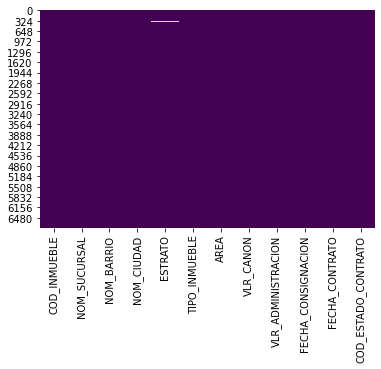

In [ ]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Normalizar - Imputar Datos

Para normalizar los datos de la columna ESTRATO, decidí usar un diccionario, pues si aplicaba LabelEnconder el orden de los datos serían contradictorios.

In [ ]:
estrato = {'SIN ASIGNAR':0, 'UNO':1, 'DOS':2, 'TRES':3, 'CUATRO':4, 'CINCO':5, 'SEIS':6, 'COMERCIAL':7}
data['ESTRATO'] = data['ESTRATO'].map(estrato)

Como los demás datos no presentan conflictos, entonces procedo a normalizarlos con LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

captura_caracteristicas = [x for x in data.columns if data[x].dtype=='object']

for col in captura_caracteristicas:
    if col in data.columns:
        i = data.columns.get_loc(col)
        data.iloc[:, i] = data.apply(lambda i:label_encoder.fit_transform(i.astype(str)), axis=0, result_type='expand')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COD_INMUEBLE         6791 non-null   int64  
 1   NOM_SUCURSAL         6791 non-null   int64  
 2   NOM_BARRIO           6791 non-null   int64  
 3   NOM_CIUDAD           6791 non-null   int64  
 4   ESTRATO              6734 non-null   float64
 5   TIPO_INMUEBLE        6791 non-null   int64  
 6   AREA                 6791 non-null   int64  
 7   VLR_CANON            6791 non-null   int64  
 8   VLR_ADMINISTRACION   6791 non-null   int64  
 9   FECHA_CONSIGNACION   6791 non-null   int64  
 10  FECHA_CONTRATO       6791 non-null   int64  
 11  COD_ESTADO_CONTRATO  6791 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 636.8 KB


In [ ]:
def imp_estrato(cols):
    estrato = cols[0]
    inmueble = cols[1]

    if pd.isnull(estrato):
        if inmueble == 0:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
        elif inmueble == 1:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
        elif inmueble == 2:
            return data[data['TIPO_INMUEBLE']==0]['ESTRATO'].mean()
    else:
        return estrato

In [ ]:
data['ESTRATO'] = data[['ESTRATO', 'TIPO_INMUEBLE']].apply(imp_estrato, axis=1)

In [ ]:
data['ESTRATO'] = data['ESTRATO'].astype('int')

In [ ]:
data.isnull().sum()

COD_INMUEBLE           0
NOM_SUCURSAL           0
NOM_BARRIO             0
NOM_CIUDAD             0
ESTRATO                0
TIPO_INMUEBLE          0
AREA                   0
VLR_CANON              0
VLR_ADMINISTRACION     0
FECHA_CONSIGNACION     0
FECHA_CONTRATO         0
COD_ESTADO_CONTRATO    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   COD_INMUEBLE         6791 non-null   int64
 1   NOM_SUCURSAL         6791 non-null   int64
 2   NOM_BARRIO           6791 non-null   int64
 3   NOM_CIUDAD           6791 non-null   int64
 4   ESTRATO              6791 non-null   int64
 5   TIPO_INMUEBLE        6791 non-null   int64
 6   AREA                 6791 non-null   int64
 7   VLR_CANON            6791 non-null   int64
 8   VLR_ADMINISTRACION   6791 non-null   int64
 9   FECHA_CONSIGNACION   6791 non-null   int64
 10  FECHA_CONTRATO       6791 non-null   int64
 11  COD_ESTADO_CONTRATO  6791 non-null   int64
dtypes: int64(12)
memory usage: 636.8 KB


## Dejar solo 2 estados en el COD_ESTADO_CONTRATO

In [ ]:
cod_estado = {0:0, 1:data['COD_ESTADO_CONTRATO'].mode(), 2:1}
data['COD_ESTADO_CONTRATO'] = data['COD_ESTADO_CONTRATO'].map(cod_estado).astype('int')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6791 entries, 0 to 6790
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   COD_INMUEBLE         6791 non-null   int64
 1   NOM_SUCURSAL         6791 non-null   int64
 2   NOM_BARRIO           6791 non-null   int64
 3   NOM_CIUDAD           6791 non-null   int64
 4   ESTRATO              6791 non-null   int64
 5   TIPO_INMUEBLE        6791 non-null   int64
 6   AREA                 6791 non-null   int64
 7   VLR_CANON            6791 non-null   int64
 8   VLR_ADMINISTRACION   6791 non-null   int64
 9   FECHA_CONSIGNACION   6791 non-null   int64
 10  FECHA_CONTRATO       6791 non-null   int64
 11  COD_ESTADO_CONTRATO  6791 non-null   int64
dtypes: int64(12)
memory usage: 636.8 KB


## Gráficas

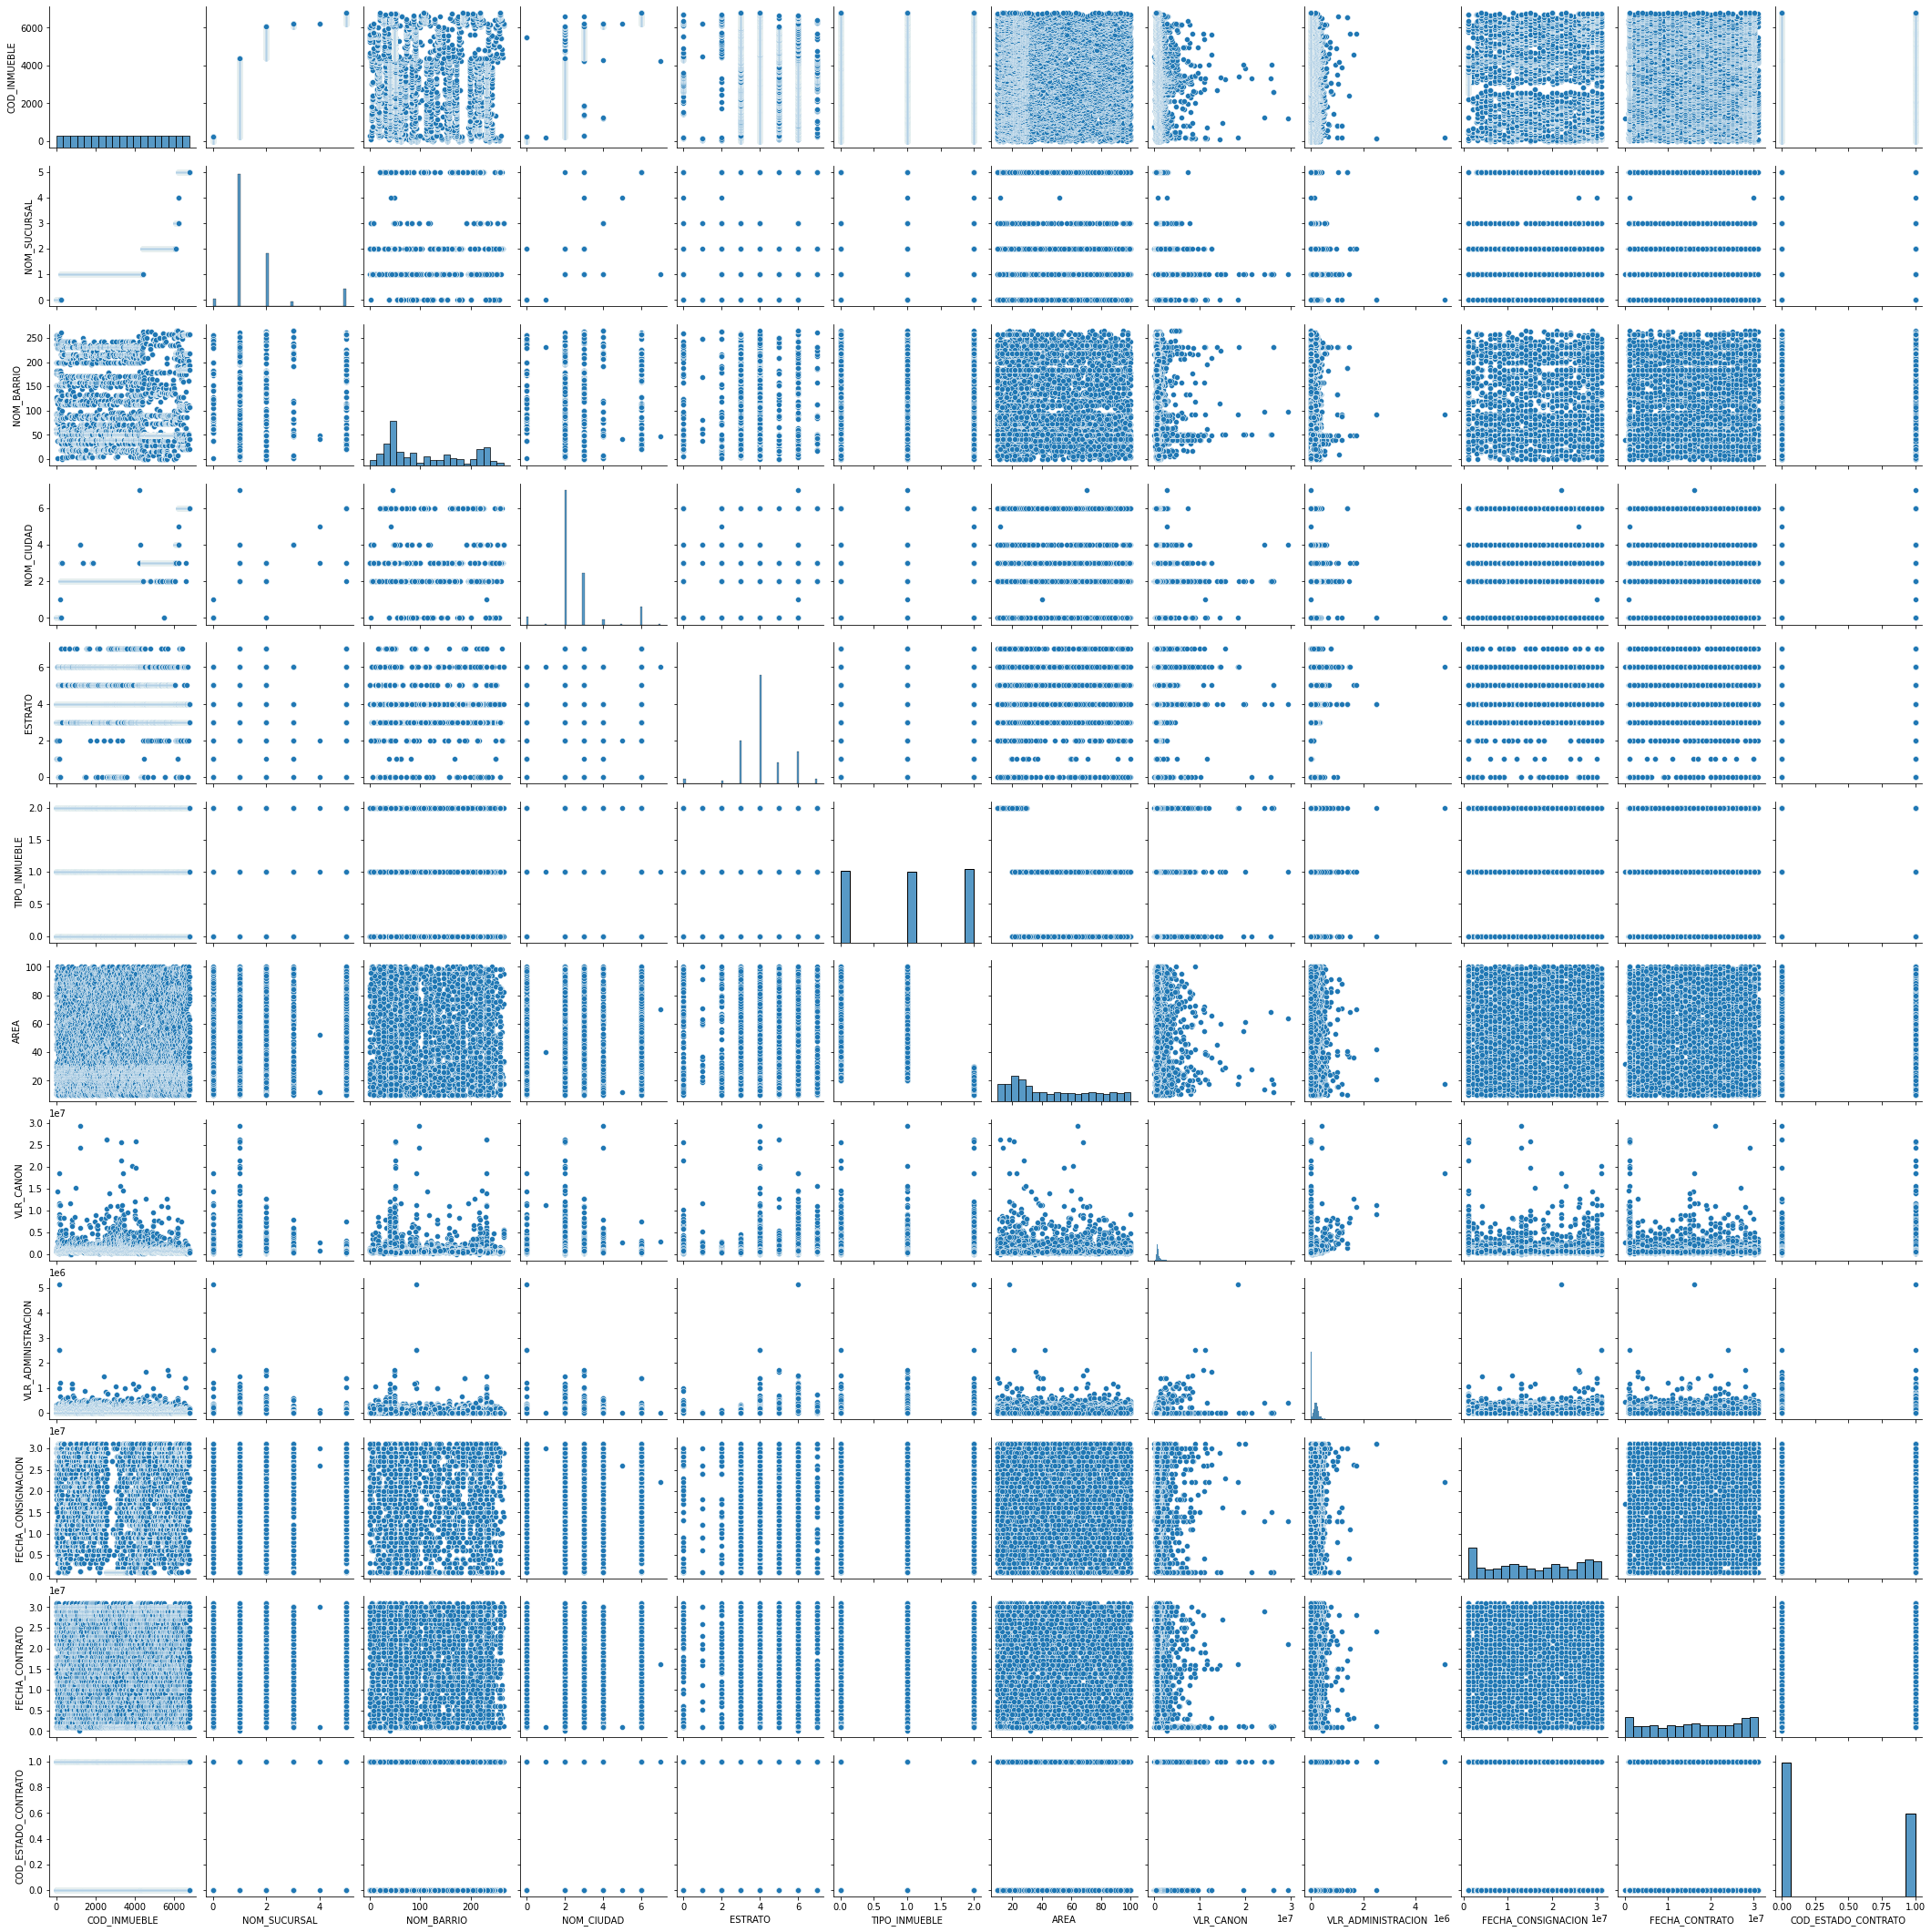

In [ ]:
sns.pairplot(data)

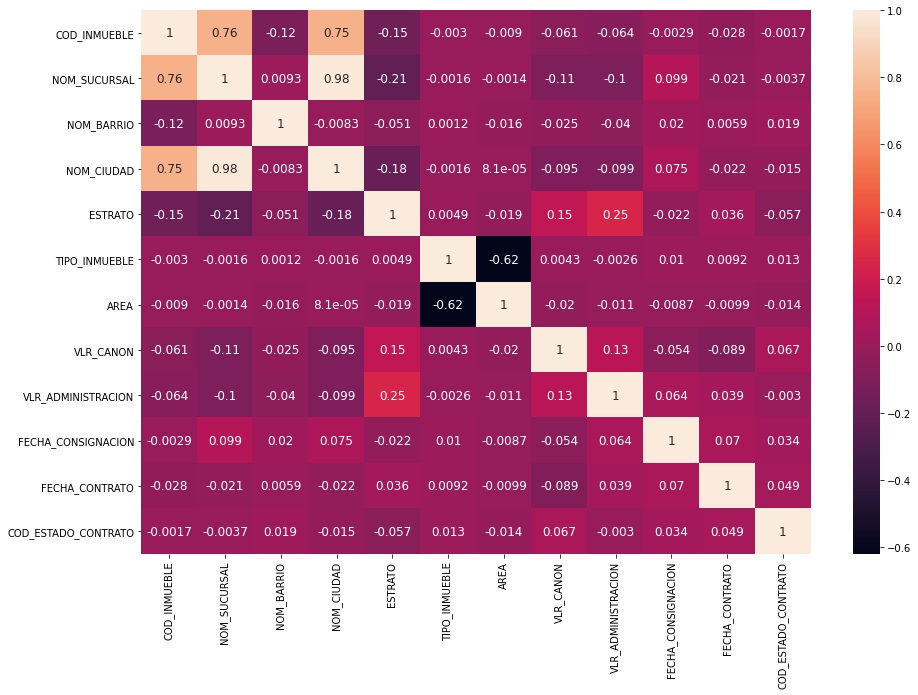

In [ ]:
corrmat = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, annot=True, annot_kws={'size': 12})

In [ ]:
def getCorrelatedFeature(corrdata, threshold):
  feature = []
  value = []
  
  for i, index in enumerate(corrdata.index):
    if abs(corrdata[index]) > threshold:
      feature.append(index)
      value.append(corrdata[index])

  df = pd.DataFrame(data=value, index=feature, columns=['Corr Value'])
  return df

In [ ]:
threshold = 0.10
corr_value = getCorrelatedFeature(corrmat['COD_ESTADO_CONTRATO'], threshold)
corr_value

,Corr Value
COD_ESTADO_CONTRATO,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


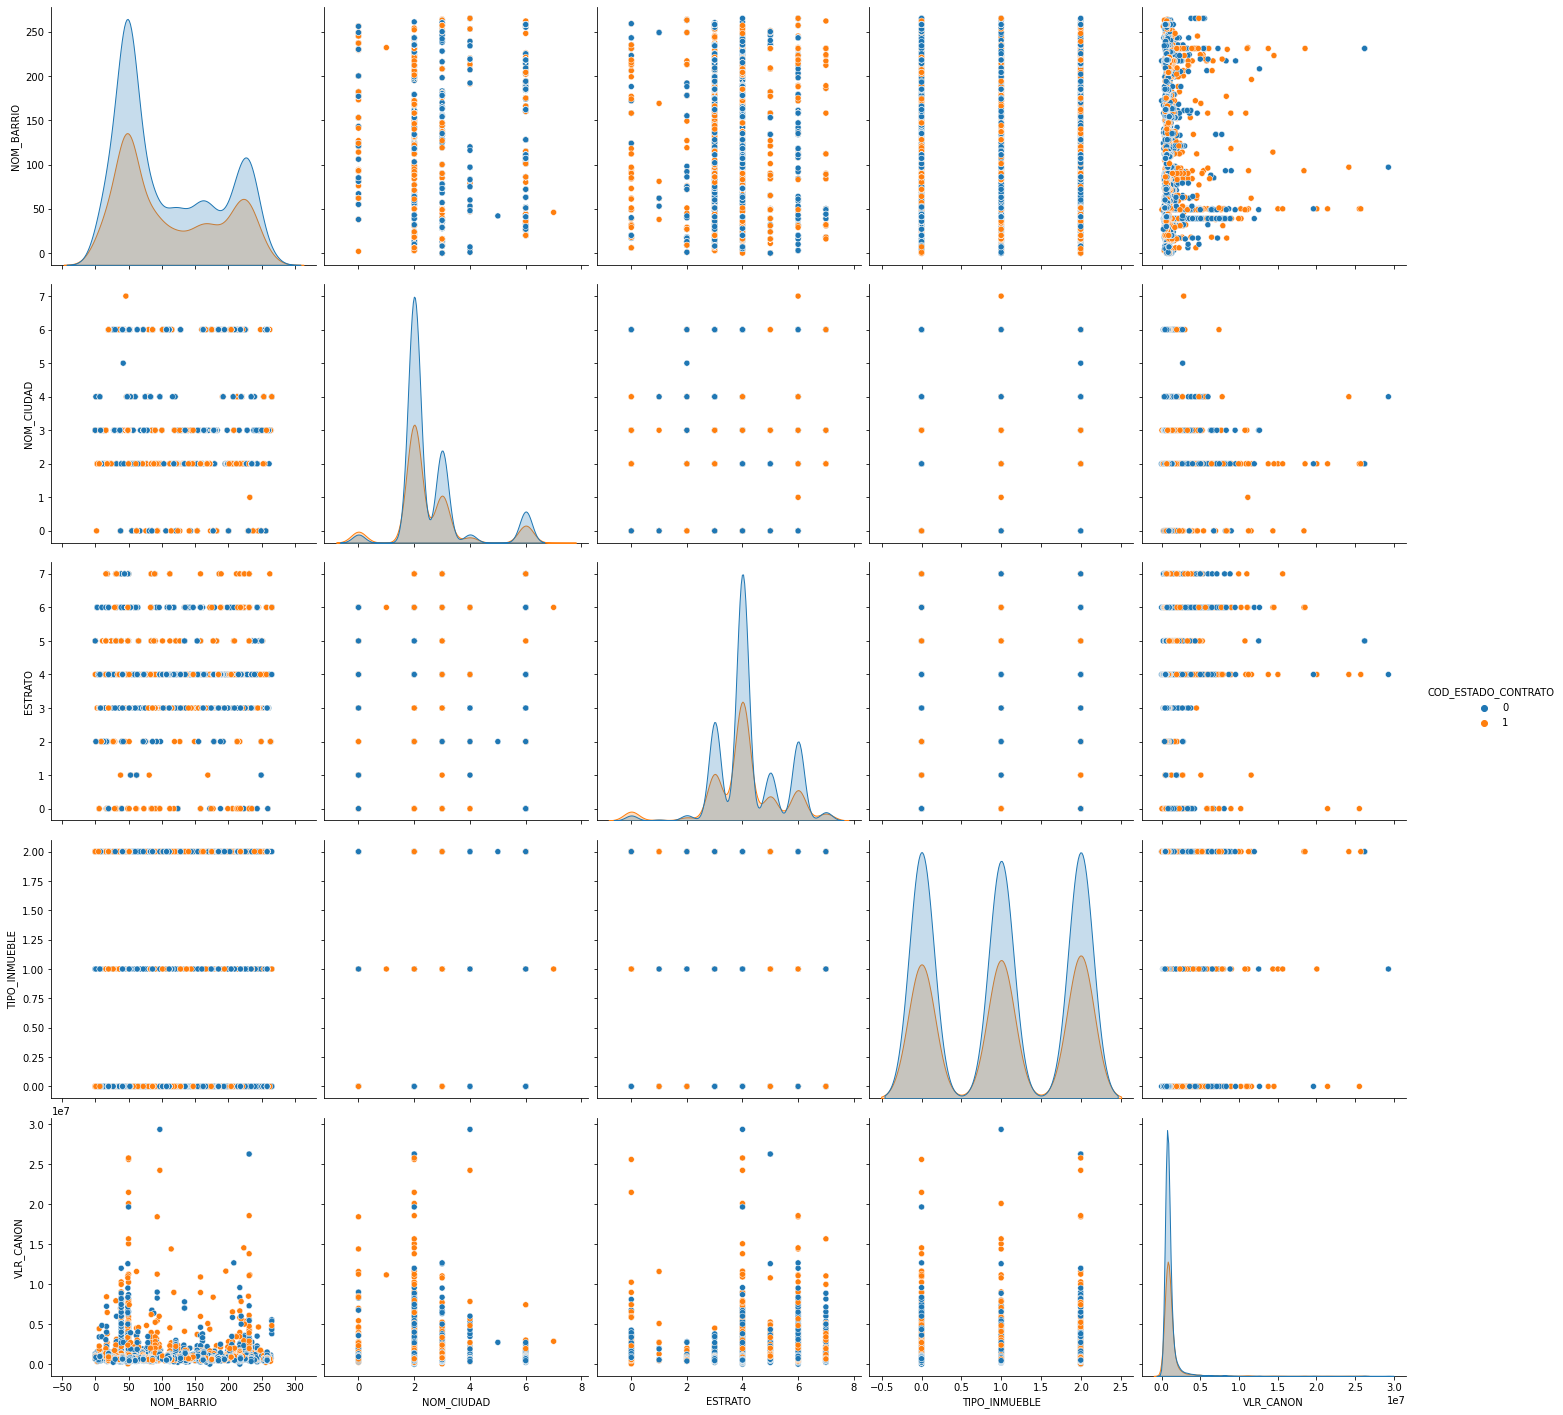

In [ ]:
sns.pairplot(data, hue='COD_ESTADO_CONTRATO', size=4, vars=['NOM_BARRIO', 'NOM_CIUDAD', 'ESTRATO', 'TIPO_INMUEBLE', 'VLR_CANON'], kind='scatter')

## Separación de los datos

In [ ]:
X = data.drop(columns=['COD_ESTADO_CONTRATO'])
y = data['COD_ESTADO_CONTRATO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

## Estarización de los datos

### Estandarización con MinMaxScaler

In [ ]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [ ]:
X_train

array([[0.23759022, 0.2       , 0.18867925, ..., 0.        , 0.66600197,
        0.74107531],
       [0.77272058, 0.4       , 0.18490566, ..., 0.03908751, 0.1332668 ,
        0.96590563],
       [0.10472824, 0.2       , 0.81886792, ..., 0.        , 0.33565961,
        0.0672276 ],
       ...,
       [0.11003093, 0.2       , 0.87169811, ..., 0.05599872, 0.69890313,
        0.58057401],
       [0.6547356 , 0.4       , 0.18490566, ..., 0.03459245, 0.06979019,
        0.22869341],
       [0.54691413, 0.2       , 0.14716981, ..., 0.07035752, 0.76669981,
        0.80733424]])

### Estandarización con StandardScaler

In [ ]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
X_train

array([[-0.9117953 , -0.50749758, -0.77611074, ..., -0.94314606,
         0.53657103,  0.67475136],
       [ 0.94706276,  0.35152521, -0.78922849, ...,  0.34374257,
        -1.09453096,  1.38907263],
       [-1.37331194, -0.50749758,  1.41455277, ..., -0.94314606,
        -0.47485473, -1.46616869],
       ...,
       [-1.35489221, -0.50749758,  1.59820121, ...,  0.90051493,
         0.63730617,  0.16481353],
       [ 0.5372237 ,  0.35152521, -0.78922849, ...,  0.19575037,
        -1.28888045, -0.95316643],
       [ 0.16268913, -0.50749758, -0.92040594, ...,  1.37325347,
         0.84488264,  0.88526641]])

## Logistic Regression: 51.32%

In [ ]:
%%time
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=6800)
logistic_regression.fit(X, y)

y_predict = logistic_regression.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_predict)
print('Exactitud= ' + str(100*accuracy) + "%")

Exactitud= 51.32482826300294%
CPU times: user 40.6 ms, sys: 27.9 ms, total: 68.5 ms
Wall time: 40.2 ms


## Decision Tree Classifier: 63.64%

In [ ]:
max_depth_lista = list(range(1, 10))

accuracy = []

for depth in max_depth_lista:
  arbol_clas = DecisionTreeClassifier(max_depth=depth, random_state=0)
  arbol_clas.fit(X_train, y_train)
  score = arbol_clas.score(X_test, y_test)
  accuracy.append(score)

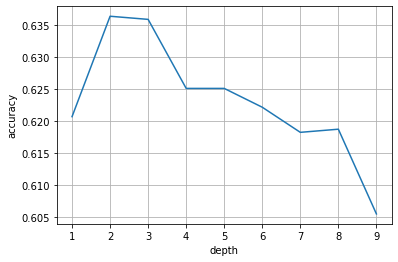

In [ ]:
plt.plot(max_depth_lista, accuracy)
plt.ylabel('accuracy')
plt.xlabel('depth')
plt.grid(True)
plt.show()

In [ ]:
%%time
arbol_clas = DecisionTreeClassifier(max_depth=2, random_state=0)

arbol_clas.fit(X_train, y_train)
accuracy = arbol_clas.score(X_test, y_test)
print(accuracy*100)

63.64082433758587
CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 16.2 ms


## SVM: 61.72%

### Linear: 61.72%

In [ ]:
%%time
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

print('Precision: ', 100*(metrics.precision_score(y_test, y_predict)))

print('Recall: ', metrics.recall_score(y_test, y_predict))

Accuracy:  61.62904808635917
Precision:  0.0
Recall:  0.0
CPU times: user 1.15 s, sys: 39.1 ms, total: 1.19 s
Wall time: 1.19 s


#### Intentando aplicar Bagging: 61.72%

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
%%time
n_estimators = 10

clf = BaggingClassifier(svm.SVC(kernel='linear', probability=True, class_weight='balanced'), n_estimators=n_estimators, max_samples=1.0/n_estimators)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))

Accuracy:  0.6172718351324828
CPU times: user 581 ms, sys: 5.27 ms, total: 586 ms
Wall time: 588 ms


In [ ]:
element, count = np.unique(y_test, return_counts=True)
element, count

(array([0, 1]), array([1257,  781]))

### Polynomial

Es posible que por recursos de mi equipo actual la ejecución del algoritmo con este kernel en grado 2, no se logre ejecutar. 

In [ ]:
clf = svm.SVC(kernel='poly', degree=2, gamma=100)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

print('Precision: ', 100*(metrics.precision_score(y_test, y_predict)))

print('Recall: ', metrics.recall_score(y_test, y_predict))

### Sigmoidal: 54.36%

In [ ]:
%%time
clf = svm.SVC(kernel='sigmoid', gamma=200, C=10000, )
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

Accuracy:  54.36702649656526
CPU times: user 570 ms, sys: 7.17 ms, total: 577 ms
Wall time: 578 ms


### RBF: 61.67%

In [ ]:
%%time
clf = svm.SVC()
param_grid = [{'kernel':['rbf'], 'gamma':[50, 5, 10, 0.5], 'C':[10, 0.1, 0.001]}]
gsv = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
gsv.fit(X_train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print("Best Accuracy: %.2f%%" % (gsv.best_score_*100))

Best HyperParameter:  {'C': 0.1, 'gamma': 50, 'kernel': 'rbf'}
Best Accuracy: 61.67%
CPU times: user 1.69 s, sys: 78.3 ms, total: 1.76 s
Wall time: 43.3 s


### Prueba con varios Kernel

In [ ]:
%%time
clf = svm.SVC()
param_grid = [{'kernel':['rbf', 'linear', 'sigmoid'], 'gamma':[50, 5, 10, 0.5], 'C':[10, 0.1, 0.001]}]
gsv = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
gsv.fit(X_train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print("Best Accuracy: %.2f%%" % (gsv.best_score_*100))

## Redes Bayesianas: 60.50%

In [ ]:
%%time
naba = GaussianNB()
naba.fit(X_train, y_train)

y_predict = naba.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_predict)
print('Accuracy: %.5f' % (accuracy*100))

Accuracy: 60.50049
CPU times: user 6.19 ms, sys: 0 ns, total: 6.19 ms
Wall time: 8.09 ms


## K-Nearest Neighbors: 62.26%

In [ ]:
neighbors = list(range(1, 50, 2))
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [ ]:
MSE = [1 - x for x in cv_scores]
MSE

[0.4603281733746132,
 0.4359323308270677,
 0.4256236178681999,
 0.4224648385670058,
 0.4182547545333922,
 0.4106802299867315,
 0.40626492702344086,
 0.3993259619637328,
 0.3976417514374171,
 0.3896452896948255,
 0.3888040689960195,
 0.385858911985847,
 0.38312251216275994,
 0.3803847854931448,
 0.3780751879699248,
 0.37891640866873066,
 0.3766015037593984,
 0.37428482972136223,
 0.3747080937638212,
 0.37407828394515696,
 0.37555285272003536,
 0.3738695267580716,
 0.37344847412649274,
 0.37660858027421507,
 0.3774502432551968]

In [ ]:
optimal_k = neighbors[MSE.index(min(MSE))]
print('The optimal number of k is: ', optimal_k)

The optimal number of k is:  45


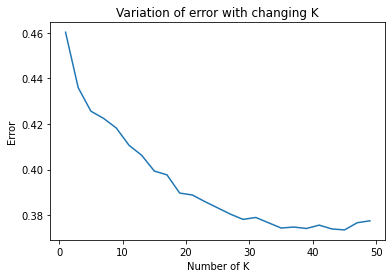

In [ ]:
plt.plot(neighbors, MSE)
plt.xlabel('Number of K')
plt.ylabel('Error')
plt.title('Variation of error with changing K')
plt.show()

In [ ]:
%%time
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
print('Accuracy: ', 100*(metrics.accuracy_score(y_test, y_predict)))

Accuracy:  62.266928361138376
CPU times: user 310 ms, sys: 3.95 ms, total: 314 ms
Wall time: 312 ms


## Ensemble Learning

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
import xgboost as xgb
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

In [ ]:
rfc = RandomForestClassifier(n_estimators=200, random_state=1)
abc = AdaBoostClassifier(n_estimators=200, random_state=1, learning_rate=0.01)
gbc = GradientBoostingClassifier(n_estimators=200, random_state=1, learning_rate=0.01)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.01, random_state=1)

In [ ]:
rfc.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print('Random Forest: ', rfc.score(X_test, y_test))
print('AdaBoost: ', abc.score(X_test, y_test))
print('Gradient Boost: ', gbc.score(X_test, y_test))
print('XGBoost: ', xgb_clf.score(X_test, y_test))

Random Forest:  0.6153091265947007
AdaBoost:  0.6290480863591756
Gradient Boost:  0.6305201177625123
XGBoost:  0.6324828263002944


In [ ]:
%%time
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)

estimators = []

model1 = RandomForestClassifier()
estimators.append(('randomForest', model1))

model2 = AdaBoostClassifier()
estimators.append(('adaBoost', model2))

model3 = GradientBoostingClassifier()
estimators.append(('gradientBoosting', model3))

model4 = xgb.XGBClassifier()
estimators.append(('xgb', model4))

ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
print('Accuracy: ', 100*(results.mean()))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Accuracy:  62.52490686996447
CPU times: user 34.2 s, sys: 61.2 ms, total: 34.3 s
Wall time: 34.2 s
